In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

In [2]:
df = pd.read_csv('../data/data.csv')
df = df.drop('id', axis=1)  # Drop ID
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})  # Encode labels
print(df.head())
print(df['diagnosis'].value_counts(normalize=True))  # Class distribution ~0.63 B, 0.37 M

   diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0          1        17.99         10.38          122.80     1001.0   
1          1        20.57         17.77          132.90     1326.0   
2          1        19.69         21.25          130.00     1203.0   
3          1        11.42         20.38           77.58      386.1   
4          1        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   symmetry_mean  ...  radius_worst  texture_worst  perimeter_worst  \
0         0.2419  ...         25.38          

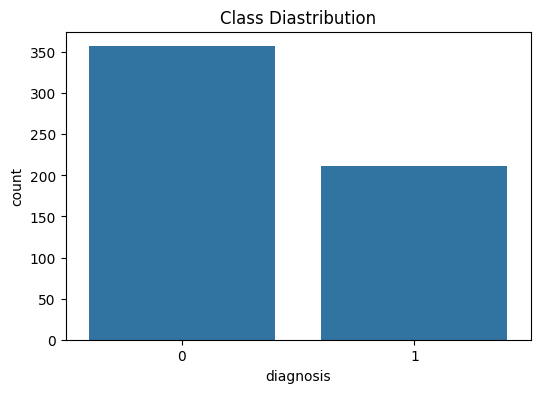

In [3]:
plt.figure(figsize=(6,4))
sns.countplot(x='diagnosis', data=df)
plt.title('Class Diastribution')
plt.show()

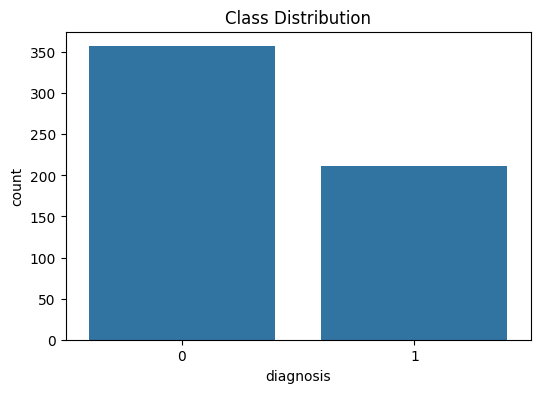

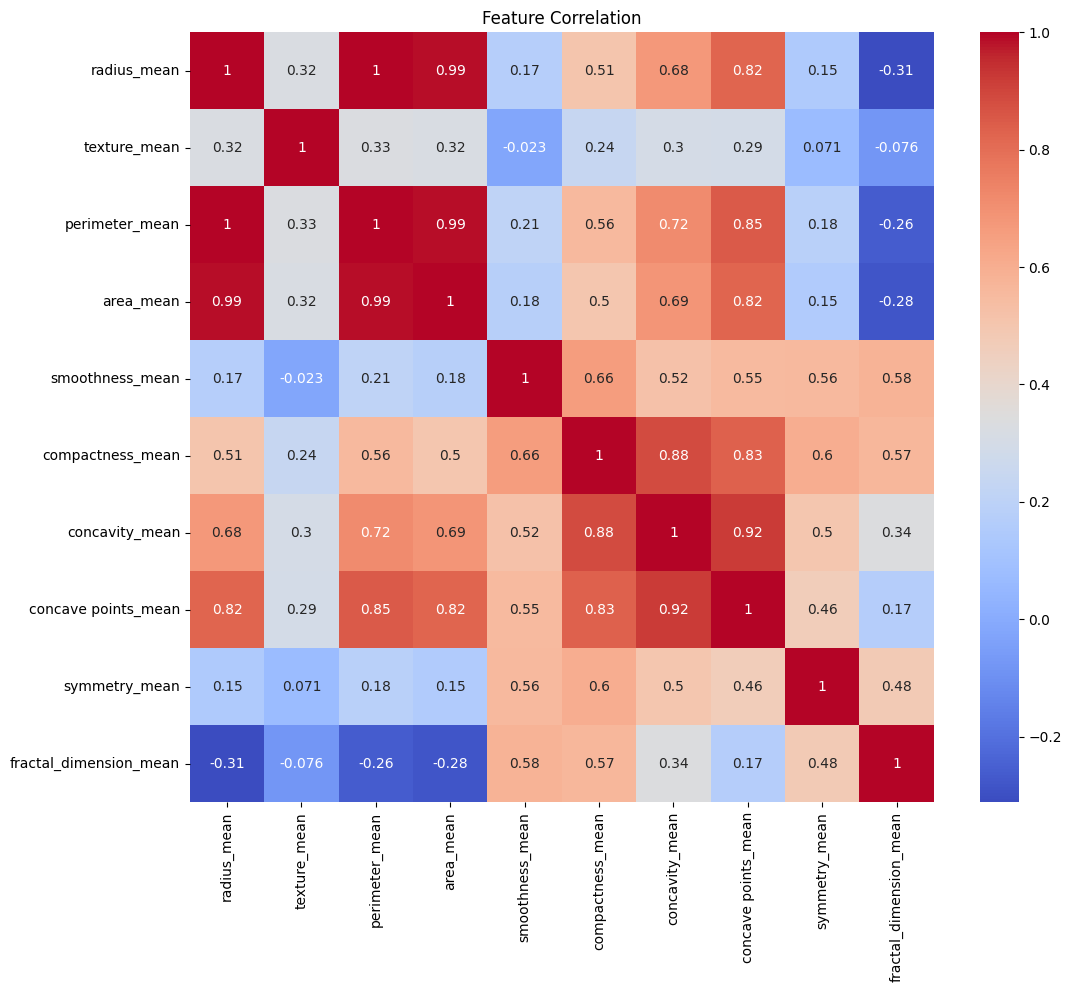

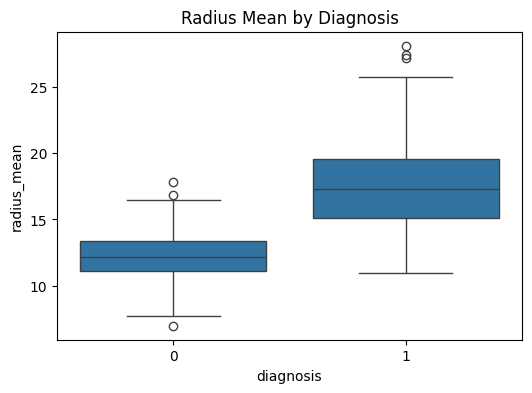

In [4]:
# Countplot
plt.figure(figsize=(6,4))
sns.countplot(x='diagnosis', data=df)
plt.title('Class Distribution')
plt.show()

# Correlation heatmap (chọn vài features quan trọng để tránh lộn xộn)
corr = df.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr.iloc[1:11,1:11], annot=True, cmap='coolwarm')  # Ví dụ top 10 features
plt.title('Feature Correlation')
plt.show()

# Boxplot so sánh features giữa classes (ví dụ radius_mean)
plt.figure(figsize=(6,4))
sns.boxplot(x='diagnosis', y='radius_mean', data=df)
plt.title('Radius Mean by Diagnosis')
plt.show()

In [ ]:
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save nếu chưa có fileX
pd.DataFrame(X_train_scaled, columns=X.columns).assign(diagnosis=y_train.values).to_csv('../data/train_scaled.csv', index=False)
pd.DataFrame(X_test_scaled, columns=X.columns).assign(diagnosis=y_test.values).to_csv('../data/test_scaled.csv', index=False)

In [6]:
model = LogisticRegression(max_iter=1000, random_state=42)
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
print(f"CV Accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
model.fit(X_train_scaled, y_train)

CV Accuracy: 0.9714 (±0.0112)


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`multi

Epoch 0/2000 - Loss: 0.693147
Epoch 100/2000 - Loss: 0.250198
Epoch 200/2000 - Loss: 0.187135
Epoch 300/2000 - Loss: 0.158738
Epoch 400/2000 - Loss: 0.142030
Epoch 500/2000 - Loss: 0.130812
Epoch 600/2000 - Loss: 0.122651
Epoch 700/2000 - Loss: 0.116385
Epoch 800/2000 - Loss: 0.111385
Epoch 900/2000 - Loss: 0.107279
Epoch 1000/2000 - Loss: 0.103831
Epoch 1100/2000 - Loss: 0.100882
Epoch 1200/2000 - Loss: 0.098324
Epoch 1300/2000 - Loss: 0.096078
Epoch 1400/2000 - Loss: 0.094085
Epoch 1500/2000 - Loss: 0.092301
Epoch 1600/2000 - Loss: 0.090692
Epoch 1700/2000 - Loss: 0.089231
Epoch 1800/2000 - Loss: 0.087896
Epoch 1900/2000 - Loss: 0.086670

Kết quả trên tập test (tự implement):
Accuracy:  0.9825
Precision: 1.0000
Recall:    0.9524
F1-Score:  0.9756
ROC-AUC:   0.9980


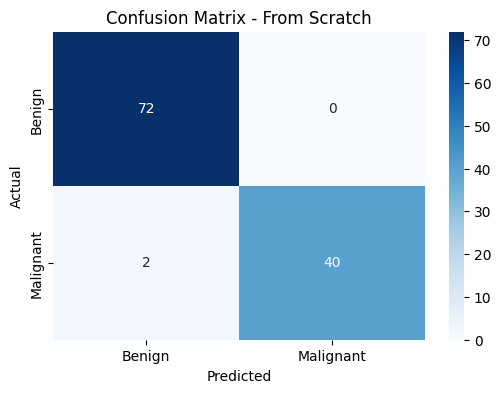

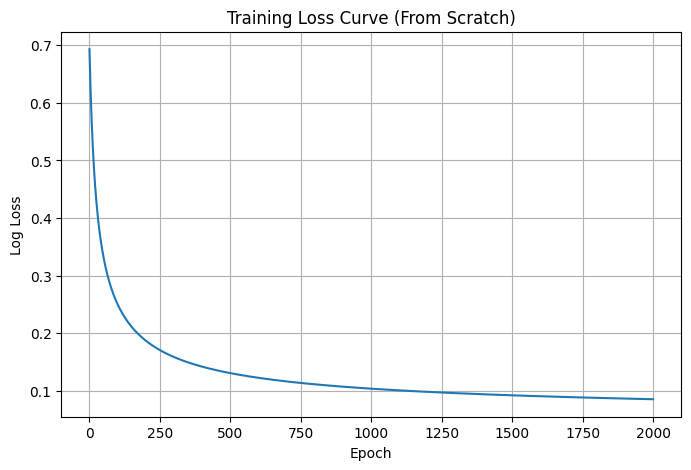


Top 10 features theo trọng số:
                 Feature  Coefficient
21         texture_worst     0.593396
20          radius_worst     0.559825
22       perimeter_worst     0.528061
23            area_worst     0.527316
7    concave points_mean     0.472777
1           texture_mean     0.472683
27  concave points_worst     0.468540
0            radius_mean     0.458356
3              area_mean     0.452970
2         perimeter_mean     0.449838


In [7]:
# Hàm sigmoid
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Hàm mất mát (Binary Cross-Entropy / Log Loss)
def log_loss(y_true, y_pred_proba):
    # Tránh log(0) bằng cách clip giá trị
    y_pred_proba = np.clip(y_pred_proba, 1e-15, 1 - 1e-15)
    return -np.mean(y_true * np.log(y_pred_proba) + (1 - y_true) * np.log(1 - y_pred_proba))

# Class Logistic Regression tự implement
class LogisticRegressionScratch:
    def __init__(self, learning_rate=0.01, epochs=1000, verbose=False):
        self.lr = learning_rate
        self.epochs = epochs
        self.verbose = verbose
        self.weights = None
        self.bias = None
        self.loss_history = []

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for epoch in range(self.epochs):
            # Forward pass
            z = np.dot(X, self.weights) + self.bias
            y_pred_proba = sigmoid(z)

            # Tính loss
            loss = log_loss(y, y_pred_proba)
            self.loss_history.append(loss)

            # Gradient
            dw = (1 / n_samples) * np.dot(X.T, (y_pred_proba - y))
            db = (1 / n_samples) * np.sum(y_pred_proba - y)

            # Update weights & bias
            self.weights -= self.lr * dw
            self.bias -= self.lr * db

            if self.verbose and epoch % 100 == 0:
                print(f"Epoch {epoch}/{self.epochs} - Loss: {loss:.6f}")

        return self

    def predict_proba(self, X):
        z = np.dot(X, self.weights) + self.bias
        return sigmoid(z)

    def predict(self, X, threshold=0.5):
        proba = self.predict_proba(X)
        return (proba >= threshold).astype(int)

# Load data (đã scale sẵn)
train_df = pd.read_csv('../data/train_scaled.csv')
test_df = pd.read_csv('../data/test_scaled.csv')

X_train = train_df.drop('diagnosis', axis=1).values  # numpy array
y_train = train_df['diagnosis'].values
X_test = test_df.drop('diagnosis', axis=1).values
y_test = test_df['diagnosis'].values

# Train mô hình tự implement
model_scratch = LogisticRegressionScratch(learning_rate=0.01, epochs=2000, verbose=True)
model_scratch.fit(X_train, y_train)

# Dự đoán trên test
y_pred = model_scratch.predict(X_test)
y_pred_proba = model_scratch.predict_proba(X_test)

# Đánh giá
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("\nKết quả trên tập test (tự implement):")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")

# Vẽ confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.title('Confusion Matrix - From Scratch')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Vẽ loss curve
plt.figure(figsize=(8, 5))
plt.plot(model_scratch.loss_history)
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.title('Training Loss Curve (From Scratch)')
plt.grid(True)
plt.show()

# In trọng số (coefficients) để so sánh
features = train_df.drop('diagnosis', axis=1).columns
coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': model_scratch.weights
}).sort_values(by='Coefficient', ascending=False)

print("\nTop 10 features theo trọng số:")
print(coef_df.head(10))

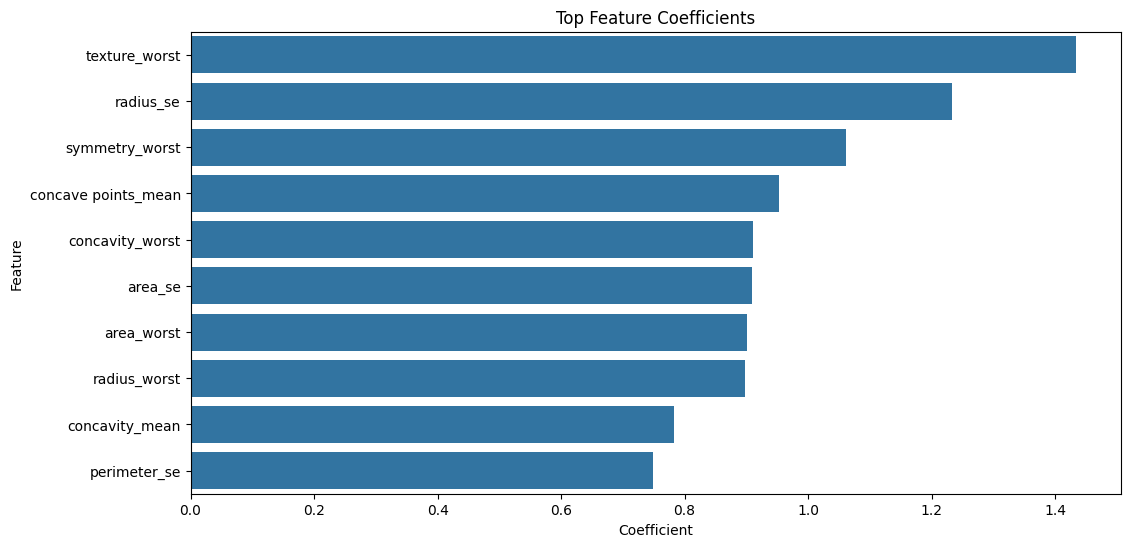

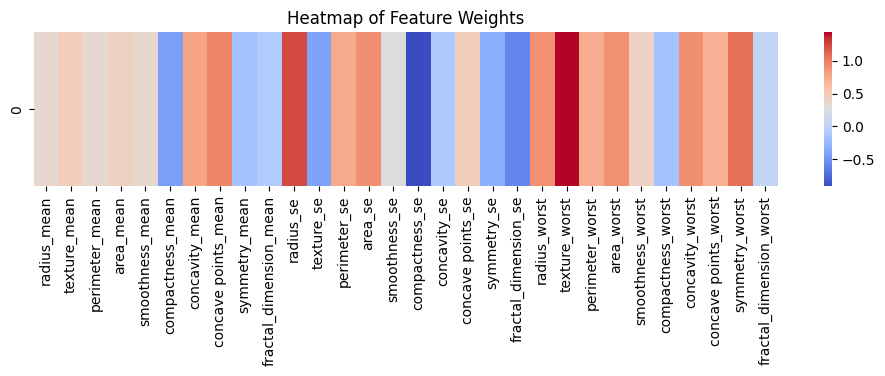

In [8]:
coefficients = model.coef_[0]
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Coefficient': coefficients}).sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x='Coefficient', y='Feature', data=importance_df.head(10))  # Top 10
plt.title('Top Feature Coefficients')
plt.show()

# Heatmap
weight_matrix = coefficients.reshape(1, -1)
plt.figure(figsize=(12,2))
sns.heatmap(weight_matrix, annot=False, cmap='coolwarm', xticklabels=features)
plt.title('Heatmap of Feature Weights')
plt.show()

In [9]:
# def sigmoid(z): return 1 / (1 + np.exp(-z))
# def log_loss(y_true, y_pred_proba): return -np.mean(y_true * np.log(y_pred_proba + 1e-15) + (1 - y_true) * np.log(1 - y_pred_proba + 1e-15))

# def train_gd(X, y, lr=0.01, epochs=500):
#     weights = np.zeros(X.shape[1])
#     bias = 0
#     losses = []
#     for _ in range(epochs):
#         z = np.dot(X, weights) + bias
#         y_hat = sigmoid(z)
#         loss = log_loss(y, y_hat)
#         losses.append(loss)
#         dw = (1 / len(X)) * np.dot(X.T, (y_hat - y))
#         db = (1 / len(X)) * np.sum(y_hat - y)
#         weights -= lr * dw
#         bias -= lr * db
#     return losses

# X_train_np = X_train_scaled
# y_train_np = y_train.values

# for lr in [0.001, 0.01, 0.1]:
#     losses = train_gd(X_train_np, y_train_np, lr=lr)
#     plt.plot(losses, label=f'LR={lr}')
# plt.xlabel('Epochs')
# plt.ylabel('Log Loss')
# plt.title('Loss over Epochs by Learning Rate')
# plt.legend()
# plt.show()

In [9]:
# Cell 9: So sánh với other models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'SVM': SVC(probability=True),
    'Random Forest': RandomForestClassifier()
}

results = []
for name, mdl in models.items():
    mdl.fit(X_train_scaled, y_train)
    y_pred = mdl.predict(X_test_scaled)
    y_pred_proba = mdl.predict_proba(X_test_scaled)[:, 1] if hasattr(mdl, 'predict_proba') else None
    acc = accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    results.append({'Model': name, 'Accuracy': acc, 'Recall': rec, 'ROC-AUC': roc})

results_df = pd.DataFrame(results)
print(results_df)  # Bảng so sánh (LR thường tốt nhất về recall - quan trọng cho y tế)

                 Model  Accuracy    Recall   ROC-AUC
0  Logistic Regression  0.964912  0.928571  0.996032
1                  KNN  0.956140  0.904762  0.982308
2        Decision Tree  0.921053  0.857143  0.907738
3                  SVM  0.973684  0.928571  0.994709
4        Random Forest  0.973684  0.928571  0.993882
